## INTRO 

- Build a simple RF model via Tensorflow DL framework. with Boston house data (adapt from the origin MNIST image data)
- Steps 
    - Step 1) Load the data, transform to the right size, and split to train,valid, test set
    - Step 2) Build the tensorflow rando forest model (tensor_forest.RandomForestGraphs)
    - Step 3) Define cost, optimizer, super-parameter ( learn-rate for example)
    - Step 4) Intiate the variables and optimizer
    - Step 5) Run the model (with tf.Session() as sess, sess.run(init))



## REF 
- https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/2_BasicModels/random_forest.ipynb

- https://gist.github.com/lynnlangit/259f7a74ee5bc957006b57861cb9f8d7 

In [1]:
# OP 
import numpy as np
import pandas as pd 
from sklearn import datasets
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# DL 
import tensorflow as tf
from tensorflow.python.ops import resources
from tensorflow.contrib.tensor_forest.python import tensor_forest


/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
# GENERATE TOY DATA 
# n_classes = 4 
# n_samples = 10000
# n_features = 20 
X, y = datasets.make_classification(n_samples=10000, n_features=20,n_informative=2,
                                    n_clusters_per_class=1,n_redundant=5,n_classes=4)

In [3]:
# SAMPLE DATA 

print ('X DAYA SAMPLE : ', X[:3])


print ('y DAYA SAMPLE : ', y[:3])

X DAYA SAMPLE :  [[ 1.45926139 -1.12510753 -0.36677095  0.46741815 -0.49458857 -1.32163612
   0.3051482  -0.07930608 -0.59478916  1.60384253  0.71363415 -0.97046529
  -0.05520398  1.20325633  0.93429905  1.09688298  0.5227903   1.71790956
   0.20832886  2.23512089]
 [-0.60750769  0.21923795  0.20209167 -0.60177868  0.34423928 -1.0693696
  -0.45353227  1.15890621 -0.8062542   1.2326347  -0.60190003 -0.80252346
   1.41957223 -0.04837158  0.4963427  -0.96691476  0.53635731 -1.39880765
  -1.44068707 -0.90482245]
 [-0.71709114  0.19117338 -0.65600827 -0.95203669 -2.17865732 -1.67762872
  -0.73202413  2.08634264 -1.65173221  1.49058417 -0.87639687 -0.96453671
  -0.1287646   0.28262985 -1.53817124 -1.42313597  0.60629808  0.37928537
  -0.73129833 -0.0554837 ]]
y DAYA SAMPLE :  [2 0 0]


In [4]:
# TRAIN-TEST SPLIT 

num_data = len(X)
train_split = 0.9
num_train = int(train_split * num_data)
num_test = num_data - num_train
x_train = X[0:num_train]
x_test = X[num_train:]
y_train = y[0:num_train]
y_test = y[num_train:]


print("Size of:")
print("- Training-set:\t\t{}".format(x_train.shape))
#print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(x_test.shape))


Size of:
- Training-set:		(9000, 20)
- Test-set:		(1000, 20)


In [5]:
# Parameters
num_steps = 1000 # Total steps to train
batch_size = 100 # The number of samples per batch
num_classes = 10 # The 10 digits
num_features = 20 # dimension of train features (20 here )
num_trees = 10
max_nodes = 1000

# Input and Target data
X = tf.placeholder(tf.float32, shape=[None, num_features])
# For random forest, labels must be integers (the class id)
Y = tf.placeholder(tf.int32, shape=[None])

# Random Forest Parameters
hparams = tensor_forest.ForestHParams(num_classes=num_classes,
                                      num_features=num_features,
                                      num_trees=num_trees,
                                      max_nodes=max_nodes).fill()

In [6]:
# Build the Random Forest
forest_graph = tensor_forest.RandomForestGraphs(hparams)
# Get training graph and loss
train_op = forest_graph.training_graph(X, Y)
loss_op = forest_graph.training_loss(X, Y)

# Measure the accuracy
infer_op, _, _ = forest_graph.inference_graph(X)
correct_prediction = tf.equal(tf.argmax(infer_op, 1), tf.cast(Y, tf.int64))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize the variables (i.e. assign their default value) and forest resources
init_vars = tf.group(tf.global_variables_initializer(),
    resources.initialize_resources(resources.shared_resources()))

INFO:tensorflow:Constructing forest with params = 
INFO:tensorflow:{'use_running_stats_method': False, 'bagged_features': None, 'base_random_seed': 0, 'dominate_method': 'bootstrap', 'max_nodes': 1000, 'num_trees': 10, 'num_outputs': 1, 'split_type': 0, 'finish_type': 0, 'split_pruning_name': 'none', 'model_name': 'all_dense', 'max_fertile_nodes': 0, 'dominate_fraction': 0.99, 'bagged_num_features': 20, 'num_splits_to_consider': 10, 'split_name': 'less_or_equal', 'leaf_model_type': 0, 'split_after_samples': 250, 'pruning_type': 0, 'prune_every_samples': 0, 'regression': False, 'bagging_fraction': 1.0, 'checkpoint_stats': False, 'num_output_columns': 11, 'inference_tree_paths': False, 'param_file': None, 'valid_leaf_threshold': 1, 'num_classes': 10, 'initialize_average_splits': False, 'early_finish_check_every_samples': 0, 'split_finish_name': 'basic', 'collate_examples': False, 'stats_model_type': 0, 'feature_bagging_fraction': 1.0, 'num_features': 20}


In [7]:
### HELP FUNC 

def get_next_batch(X_train,Y_train):
    idxs = np.random.permutation(X_train.shape[0]) #shuffled ordering
    X_random_batch  = X_train[idxs]
    Y_random_batch = Y_train[idxs]
    return X_random_batch,  Y_random_batch



Step 1, Loss: -1.000000, Acc: 0.872222
Step 50, Loss: -1001.000000, Acc: 0.984111
Step 100, Loss: -1001.000000, Acc: 0.984111
Step 150, Loss: -1001.000000, Acc: 0.984111
Step 200, Loss: -1001.000000, Acc: 0.984111
Step 250, Loss: -1001.000000, Acc: 0.984111
Step 300, Loss: -1001.000000, Acc: 0.984111
Step 350, Loss: -1001.000000, Acc: 0.984111
Step 400, Loss: -1001.000000, Acc: 0.984111
Step 450, Loss: -1001.000000, Acc: 0.984111
Step 500, Loss: -1001.000000, Acc: 0.984111
Step 550, Loss: -1001.000000, Acc: 0.984111
Step 600, Loss: -1001.000000, Acc: 0.984111
Step 650, Loss: -1001.000000, Acc: 0.984111
Step 700, Loss: -1001.000000, Acc: 0.984111
Step 750, Loss: -1001.000000, Acc: 0.984111
Step 800, Loss: -1001.000000, Acc: 0.984111
Step 850, Loss: -1001.000000, Acc: 0.984111
Step 900, Loss: -1001.000000, Acc: 0.984111
Step 950, Loss: -1001.000000, Acc: 0.984111
Step 1000, Loss: -1001.000000, Acc: 0.984111


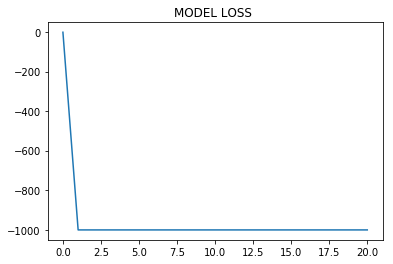

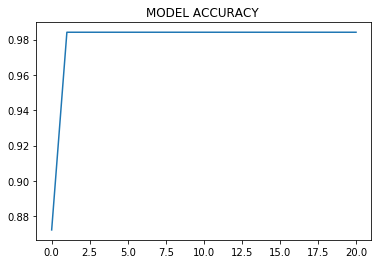

Test Accuracy: 0.977


In [8]:
# Start TensorFlow session
sess = tf.train.MonitoredSession()

# Run the initializer
sess.run(init_vars)

# Training

output = [[], []] # get the model train history, i.e. : [[loss],[acc]]


for i in range(1, num_steps + 1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    ####################################################################################
    #                                                                                  #
    # MODIFY THE CODE HERE (MNIST -> USER DEFINED DATASET)                             #
    ####################################################################################
    
    batch_x, batch_y = get_next_batch(x_train,y_train)
    _, l = sess.run([train_op, loss_op], feed_dict={X: batch_x, Y: batch_y})
    if i % 50 == 0 or i == 1:
        acc = sess.run(accuracy_op, feed_dict={X: batch_x, Y: batch_y})
        output[0].append(l)
        output[1].append(acc)
        print('Step %i, Loss: %f, Acc: %f' % (i, l, acc))
        
plt.plot(output[0])
plt.title('MODEL LOSS ')
plt.show()
plt.plot(output[1])
plt.title('MODEL ACCURACY ')
plt.show()

# Test Model
test_x, test_y = x_test, y_test
print("Test Accuracy:", sess.run(accuracy_op, feed_dict={X: test_x, Y: test_y}))


In [9]:
# end of analysis 